In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import time
from scipy.stats import linregress

#from api_keys import api_key
from citipy import citipy

In [2]:
csvpath = "../gt-prj1-crime-data/crime_09_20_clean_dupsdeleted.csv"
csvfile = pd.read_csv(csvpath,encoding="utf-8")
crime_df = pd.DataFrame(csvfile)
crime_df.head()

C:\Users\joeki\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,offense_id,occur_date,occur_time,location,UC2_Literal,neighborhood,lat,long,occur_year,occur_month
0,193651657,12/31/2019,1458,1388 LA FRANCE ST NE,LARCENY-NON VEHICLE,Edgewood,33.76053,-84.34220,2019,12
1,193651031,12/31/2019,1300,443 MORELAND AVE SE,LARCENY-NON VEHICLE,Ormewood Park,33.74179,-84.34973,2019,12
2,193650870,12/31/2019,1200,2711 METROPOLITAN PKWY SW,LARCENY-NON VEHICLE,Hammond Park,33.68092,-84.40814,2019,12
3,193651019,12/31/2019,1300,969 MARIETTA ST NW,LARCENY-NON VEHICLE,Marietta Street Artery,33.77828,-84.40910,2019,12
4,193651039,12/31/2019,1300,3070 BOLLING WAY NE,LARCENY-NON VEHICLE,Buckhead Village,33.83888,-84.37995,2019,12


In [3]:
##  Put the months into bins and made "Seasons"
bins = [0,3,6,9,12]
seasons = ["Winter","Spring","Summer","Autumn"]

crime_df["Seasons"] = pd.cut(crime_df["occur_month"],bins,labels=seasons,include_lowest=True, right = False)
crime_df

,offense_id,occur_date,occur_time,location,UC2_Literal,neighborhood,lat,long,occur_year,occur_month,Seasons
0,193651657,12/31/2019,1458,1388 LA FRANCE ST NE,LARCENY-NON VEHICLE,Edgewood,33.76053,-84.34220,2019,12,NaN
1,193651031,12/31/2019,1300,443 MORELAND AVE SE,LARCENY-NON VEHICLE,Ormewood Park,33.74179,-84.34973,2019,12,NaN
2,193650870,12/31/2019,1200,2711 METROPOLITAN PKWY SW,LARCENY-NON VEHICLE,Hammond Park,33.68092,-84.40814,2019,12,NaN
3,193651019,12/31/2019,1300,969 MARIETTA ST NW,LARCENY-NON VEHICLE,Marietta Street Artery,33.77828,-84.40910,2019,12,NaN
4,193651039,12/31/2019,1300,3070 BOLLING WAY NE,LARCENY-NON VEHICLE,Buckhead Village,33.83888,-84.37995,2019,12,NaN
...,...,...,...,...,...,...,...,...,...,...,...
364243,200011298,1/1/2020,14:45,2630 MARTIN L KING JR DR SW,AUTO THEFT,Harland Terrace,33.75377,-84.47405,2020,1,Winter
364244,200011823,1/1/2020,20:00,540 HUMPHRIES ST SW,AUTO THEFT,Mechanicsville,33.73990,-84.40488,2020,1,Winter
364245,200020105,1/1/2020,21:45,1174 EUCLID AVE NE,AUTO THEFT,Inman Park,33.76553,-84.34934,2020,1,Winter
364246,200020704,1/1/2020,20:00,383 RALPH MCGILL BLVD NE,AUTO THEFT,Old Fourth Ward,33.76391,-84.37489,2020,1,Winter


In [4]:
## IDing the different crimes
compartmentalize_crimes = crime_df["UC2_Literal"].unique()
compartmentalize_crimes
print(f"There are {len(compartmentalize_crimes)} different crimes in the 'UC2_Literal' column.")
compartmentalize_crimes

There are 13 different crimes in the 'UC2_Literal' column.


array(['LARCENY-NON VEHICLE', 'ROBBERY-PEDESTRIAN', 'HOMICIDE',
       'AUTO THEFT', 'BURGLARY-NONRES', 'LARCENY-FROM VEHICLE',
       'AGG ASSAULT', 'BURGLARY-RESIDENCE', 'ROBBERY-RESIDENCE',
       'ROBBERY-COMMERCIAL', 'MANSLAUGHTER', 'ROBBERY', 'BURGLARY'],
      dtype=object)

In [5]:
## IDing the different neighborhoods
compartmentalize_hoods = crime_df["neighborhood"].unique()
compartmentalize_hoods
print(f"There are {len(compartmentalize_hoods)} different neighborhoods in the 'neighborhood' column.")
compartmentalize_hoods

There are 244 different neighborhoods in the 'neighborhood' column.


array(['Edgewood', 'Ormewood Park', 'Hammond Park',
       'Marietta Street Artery', 'Buckhead Village', 'Inman Park',
       'Vine City', 'Downtown', 'Sylvan Hills', 'Custer/McDonough/Guice',
       'Old Fourth Ward', 'Lindridge/Martin Manor', 'Rosedale Heights',
       'Carroll Heights', 'Southwest', nan, 'Peachtree Hills', 'Mays',
       'Center Hill', 'Brookwood Hills', 'Ben Hill Terrace',
       'East Atlanta', 'Midtown', 'Castleberry Hill', 'Atlantic Station',
       'Hunter Hills', 'Westview', 'Cascade Avenue/Road', 'Pittsburgh',
       'Peoplestown', 'Carey Park', 'Heritage Valley', 'Harland Terrace',
       'Loring Heights', 'Lakewood Heights', 'Venetian Hills',
       'Lake Claire', 'Piedmont Heights', 'Greenbriar Village',
       'Mechanicsville', 'Underwood Hills', 'Home Park',
       'Wildwood (NPU-C)', 'West Paces Ferry/Northside', 'Candler Park',
       'Poncey-Highland', 'East Chastain Park', 'Virginia Highland',
       'Blandtown', 'Cabbagetown', 'Campbellton Road',
  

In [6]:
# ## The "ibr_code" column has been dropped
# ## IDing the different codes
# compartmentalize_ibr_codes = crime_df["ibr_code"].unique()
# compartmentalize_ibr_codes
# print(f"There are {len(compartmentalize_ibr_codes)} different codes in the 'ibr_code' column.")
# compartmentalize_ibr_codes

In [7]:
# homicide_df_df = crime_df.loc[(crime_df["UC2_Literal"]== "HOMICIDE") & (crime_df["Seasons"]== "Summer") | (crime_df["Seasons"]== "Winter")]
# homicide_df_df

In [8]:
crime_df_data = crime_df.groupby(['occur_year','Seasons'])
crime_df_data.count().head(50)

offense_id  occur_date  occur_time  location  UC2_Literal  \
occur_year Seasons                                                              
2009       Winter         6066        6066        6066      6066         6066   
           Spring         9514        9514        9514      9514         9514   
           Summer        10735       10735       10735     10735        10735   
           Autumn         9592        9592        9592      9592         9592   
2010       Winter         4749        4749        4749      4749         4749   
           Spring         8800        8800        8800      8800         8800   
           Summer         9567        9567        9567      9567         9567   
           Autumn         9439        9439        9439      9439         9439   
2011       Winter         4594        4594        4594      4594         4594   
           Spring         8744        8744        8744      8744         8744   
           Summer         9741        9741        9741      9741         9741   
           Autumn         8873        8873        8873      8873         8873   
2012       Winter         4747        4747        4747      4747         4747   
           Spring         8145        8145        8145      8145         8145   
           Summer         9199        9199        9199      9199         9199   
           Autumn         8397        8397        8397      8397         8397   
2013       Winter         5035        5035        5035      5035         5035   
           Spring         7988        7988        7988      7988         7988   
           Summer         8798        8798        8798      8798         8798   
           Autumn         7925        7925        7925      7924         7925   
2014       Winter         4359        4359        4359      4359         4359   
           Spring         7250        7250        7250      7250         7250   
           Summer         8328        8328        8328      8328         8328   
           Autumn         8228        8228        8228      8228         8228   
2015       Winter         4380        4380        4380      4380         4380   
           Spring         7257        7257        7257      7256         7257   
           Summer         8246        8246        8246      8246         8246   
           Autumn         7752        7752        7752      7752         7752   
2016       Winter         4340        4340        4340      4340         4340   
           Spring         6920        6920        6920      6920         6920   
           Summer         7696        7696        7696      7696         7696   
           Autumn         7495        7495        7495      7495         7495   
2017       Winter         3885        3885        3885      3885         3885   
           Spring         5940        5940        5940      5940         5940   
           Summer         6887        6887        6887      6887         6887   
           Autumn         7283        7283        7283      7283         7283   
2018       Winter         3946        3946        3946      3946         3946   
           Spring         6099        6099        6099      6099         6099   
           Summer         6682        6682        6682      6682         6682   
           Autumn         6459        6459        6459      6459         6459   
2019       Winter         3656        3656        3656      3656         3656   
           Spring         5800        5800        5800      5800         5800   
           Summer         6703        6703        6703      6703         6703   
           Autumn         6485        6485        6485      6485         6485   
2020       Winter         3960        3960        3960      3960         3960   
           Spring         4043        4043        4043      4043         4043   
           Summer         5065        5065        5065      5065         5065   
           Autumn         6366        6366        6

In [9]:
crime_df_data = crime_df.groupby(['occur_year','Seasons'])
crime_count_df = crime_df_data['offense_id'].count()
crime_count_df.head()

occur_year  Seasons
2009        Winter      6066
            Spring      9514
            Summer     10735
            Autumn      9592
2010        Winter      4749
Name: offense_id, dtype: int64

In [10]:
three_year_crime_data = crime_count_df.loc[2018:2020, :]
three_year_crime_data = three_year_crime_data.reset_index()
three_year_crime_data.head()

,occur_year,Seasons,offense_id
0,2018,Winter,3946
1,2018,Spring,6099
2,2018,Summer,6682
3,2018,Autumn,6459
4,2019,Winter,3656


(<AxesSubplot:xlabel='occur_year', ylabel='offense_id'>,)

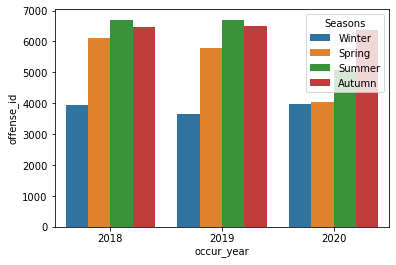

In [11]:
sns.barplot(x = 'occur_year', y = 'offense_id', hue = 'Seasons', data = three_year_crime_data),

In [12]:
season_crime_data =crime_df.groupby(["Seasons", "UC2_Literal"])['offense_id'].count()
season_crime_data.head()

season_crime_df = pd.DataFrame(season_crime_data).reset_index()
season_crime_df.head()

,Seasons,UC2_Literal,offense_id
0,Winter,AGG ASSAULT,3697
1,Winter,AUTO THEFT,7653
2,Winter,BURGLARY,352
3,Winter,BURGLARY-NONRES,1756
4,Winter,BURGLARY-RESIDENCE,7359


In [13]:
season_crime_df = pd.DataFrame(season_crime_data).reset_index()
season_crime_df.head()

,Seasons,UC2_Literal,offense_id
0,Winter,AGG ASSAULT,3697
1,Winter,AUTO THEFT,7653
2,Winter,BURGLARY,352
3,Winter,BURGLARY-NONRES,1756
4,Winter,BURGLARY-RESIDENCE,7359


<AxesSubplot:title={'center':'Crimes Commited by Seasons from 2009-2020'}, xlabel='Seasons', ylabel='offense_id'>

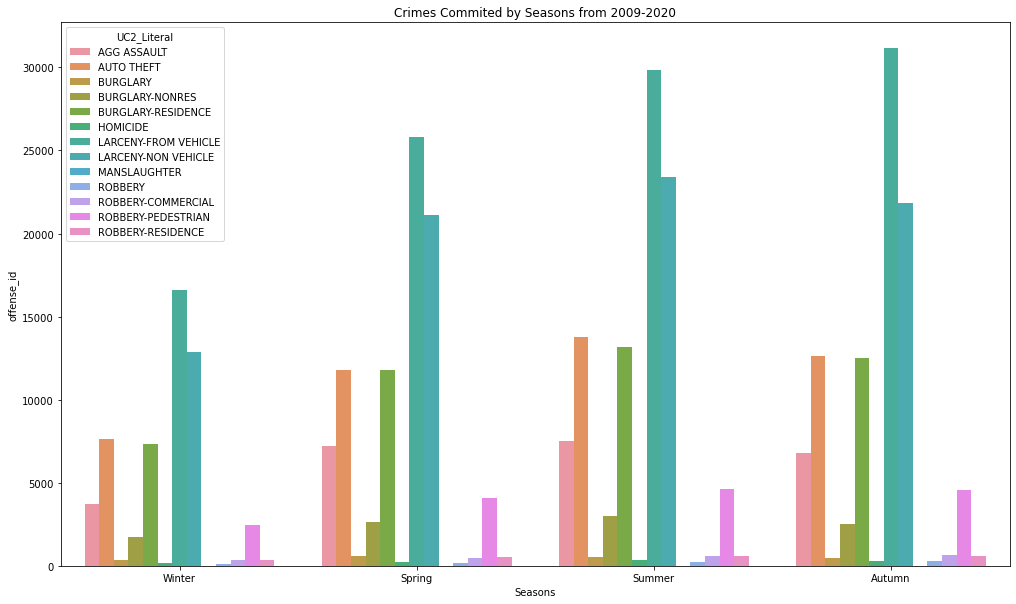

In [14]:
#Use Matplotlib to set figure size first
plt.figure(figsize=(17,10))
plt.title("Crimes Commited by Seasons from 2009-2020")
#Plot with seaborn
sns.barplot(x = 'Seasons', y = 'offense_id', hue = 'UC2_Literal', data = season_crime_df)


<AxesSubplot:title={'center':'Crimes from 2009-2019'}, ylabel='offense_id'>

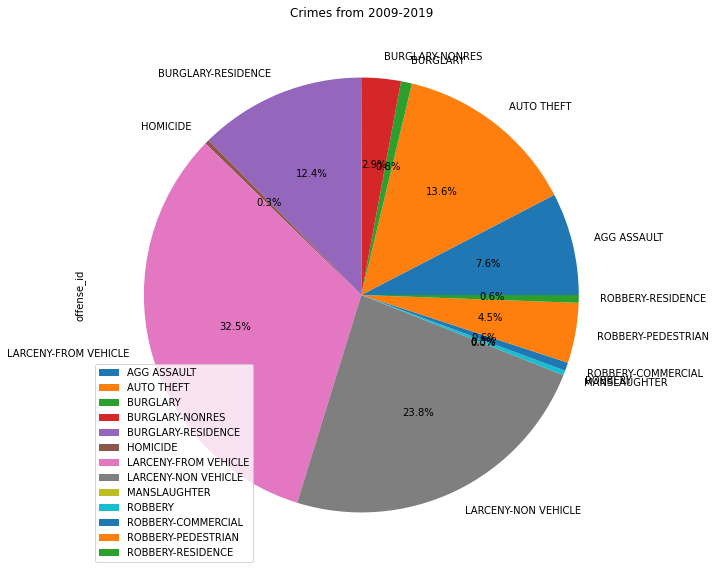

In [15]:
crime_df.groupby(['UC2_Literal']).sum().plot(kind='pie', y='offense_id',figsize=(15,10), autopct='%1.1f%%',title=("Crimes from 2009-2019"))

In [16]:
#Consolidated dataframe headings to match what's going on in 2020 with robberies and burglaries

crime_consolidated_df = crime_df.replace(
    {"BURGLARY-NONRES": "BURGLARY", "BURGLARY-RESIDENCE": "BURGLARY", "ROBBERY-COMMERCIAL" : "ROBBERY",
     "ROBBERY-PEDESTRIAN": "ROBBERY", "ROBBERY-RESIDENCE" : "ROBBERY"})
crime_consolidated_df.head()

,offense_id,occur_date,occur_time,location,UC2_Literal,neighborhood,lat,long,occur_year,occur_month,Seasons
0,193651657,12/31/2019,1458,1388 LA FRANCE ST NE,LARCENY-NON VEHICLE,Edgewood,33.76053,-84.34220,2019,12,NaN
1,193651031,12/31/2019,1300,443 MORELAND AVE SE,LARCENY-NON VEHICLE,Ormewood Park,33.74179,-84.34973,2019,12,NaN
2,193650870,12/31/2019,1200,2711 METROPOLITAN PKWY SW,LARCENY-NON VEHICLE,Hammond Park,33.68092,-84.40814,2019,12,NaN
3,193651019,12/31/2019,1300,969 MARIETTA ST NW,LARCENY-NON VEHICLE,Marietta Street Artery,33.77828,-84.40910,2019,12,NaN
4,193651039,12/31/2019,1300,3070 BOLLING WAY NE,LARCENY-NON VEHICLE,Buckhead Village,33.83888,-84.37995,2019,12,NaN


<AxesSubplot:title={'center':'Crimes from 2009-2019'}, ylabel='offense_id'>

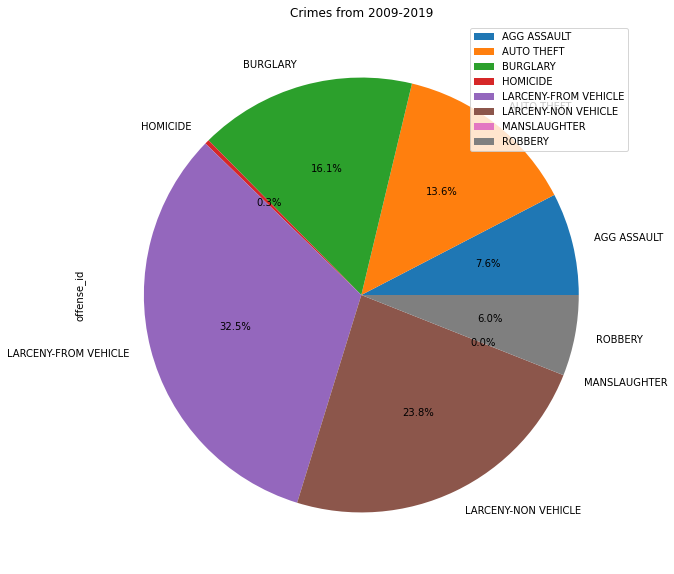

In [17]:
crime_consolidated_df.groupby(['UC2_Literal']).sum().plot(kind='pie', y='offense_id',figsize=(15,10), autopct='%1.1f%%',title=("Crimes from 2009-2019"))

<AxesSubplot:title={'center':'Crimes Commited by Seasons from 2009-2020'}, xlabel='Seasons', ylabel='offense_id'>

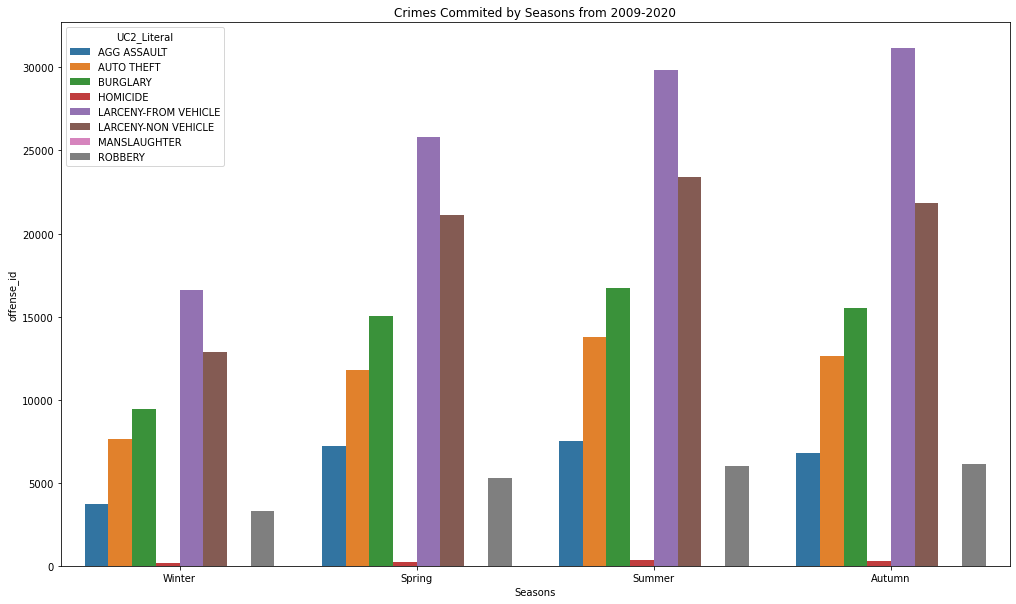

In [18]:
season_crime_data_cons = crime_consolidated_df.groupby(["Seasons", "UC2_Literal"])['offense_id'].count()
season_crime_data_cons.head()

season_crime_cons_df = pd.DataFrame(season_crime_data_cons).reset_index()
season_crime_cons_df.head()

#Use Matplotlib to set figure size first
plt.figure(figsize=(17,10))
plt.title("Crimes Commited by Seasons from 2009-2020")
#Plot with seaborn
sns.barplot(x = 'Seasons', y = 'offense_id', hue = 'UC2_Literal', data = season_crime_cons_df)

In [36]:
violent_df = crime_consolidated_df.loc[(crime_df["UC2_Literal"]== "AGG ASSAULT") | (crime_df["UC2_Literal"]== "HOMICIDE") | (crime_df["UC2_Literal"]== "MANSLAUGHTER") ]  
violent_df.head()

# larceny_vehicle_df = crime_consolidated_df.loc[(crime_df["UC2_Literal"]== "LARCENY-FROM VEHICLE")] 
# larceny_vehicle_df.head()

,offense_id,occur_date,occur_time,location,UC2_Literal,neighborhood,lat,long,occur_year,occur_month,Seasons
22,193650406,12/31/2019,100,4065 SOUTHWOOD CIR SW,LARCENY-FROM VEHICLE,Ben Hill Terrace,33.69549,-84.52088,2019,12,NaN
23,193650987,12/31/2019,1310,1687 MAY AVE SE,LARCENY-FROM VEHICLE,East Atlanta,33.73870,-84.33251,2019,12,NaN
24,193651001,12/31/2019,1020,1080 PEACHTREE ST NE,LARCENY-FROM VEHICLE,Midtown,33.78409,-84.38353,2019,12,NaN
25,193651605,12/31/2019,1615,180 WALKER ST SW,LARCENY-FROM VEHICLE,Castleberry Hill,33.74964,-84.40132,2019,12,NaN
26,193651845,12/31/2019,1855,99 KROG ST NE,LARCENY-FROM VEHICLE,Inman Park,33.75667,-84.36390,2019,12,NaN


<AxesSubplot:title={'center':'Violent Crimes by Seasons from 2009-2020'}, xlabel='Seasons', ylabel='offense_id'>

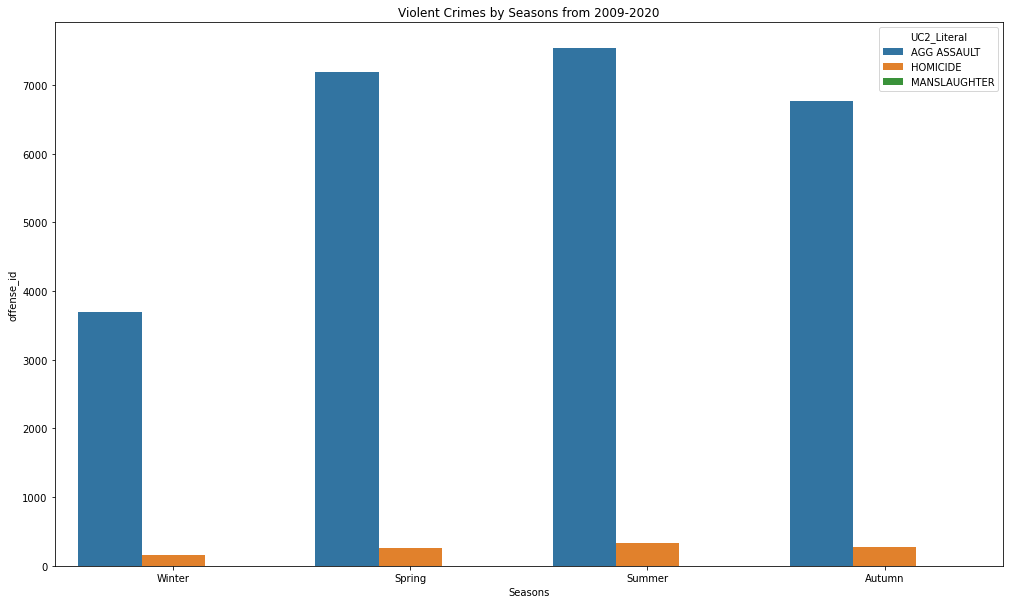

In [35]:
violent_df_df =violent_df.groupby(["Seasons", "UC2_Literal"])['offense_id'].count()
violent_df_df.head()

violent_df_df_reset = pd.DataFrame(violent_df_df).reset_index()
violent_df_df_reset.head()

#Use Matplotlib to set figure size first
plt.figure(figsize=(17,10))
plt.title("Violent Crimes by Seasons from 2009-2020")
#Plot with seaborn
sns.barplot(x = 'Seasons', y = 'offense_id', hue = 'UC2_Literal', data = violent_df_df_reset)

<AxesSubplot:title={'center':'Crimes Commited by Seasons from 2018-2020'}, xlabel='Seasons', ylabel='offense_id'>

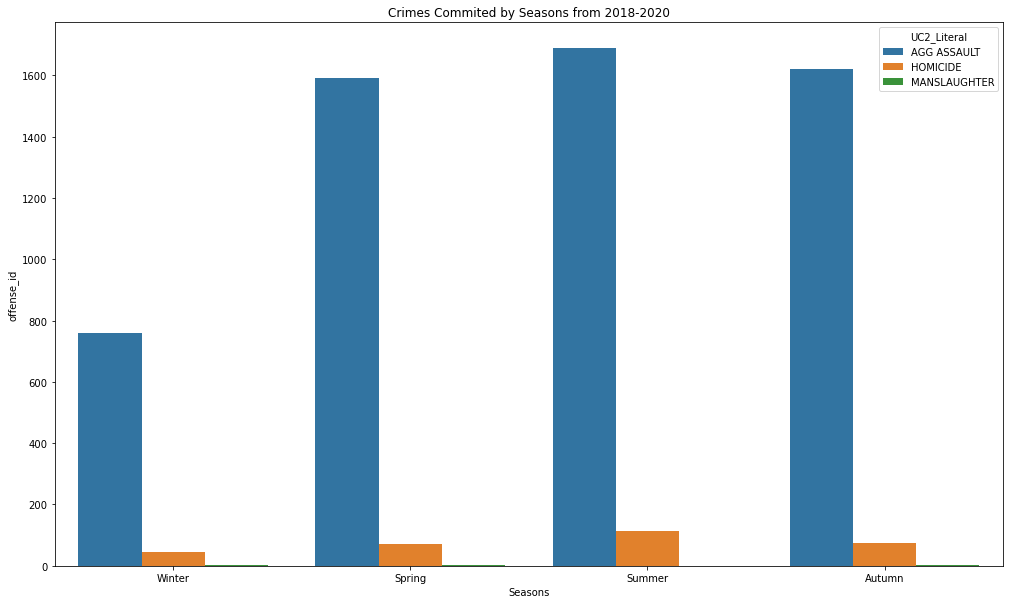

In [26]:
violent_3 = violent_df.loc[(violent_df["occur_year"]==2018) | (violent_df["occur_year"]==2019) | (violent_df["occur_year"]==2020)]
violent_3

violent_3_df =violent_3.groupby(["Seasons", "UC2_Literal"])['offense_id'].count()
violent_3_df.head()

violent_3_df_reset = pd.DataFrame(violent_3_df).reset_index()
violent_3_df_reset.head()

#Use Matplotlib to set figure size first
plt.figure(figsize=(17,10))
plt.title("Crimes Commited by Seasons from 2018-2020")
#Plot with seaborn
sns.barplot(x = 'Seasons', y = 'offense_id', hue = 'UC2_Literal', data = violent_3_df_reset)

<AxesSubplot:title={'center':'Vehicle Crimes by Seasons from 2009-2020'}, xlabel='Seasons', ylabel='offense_id'>

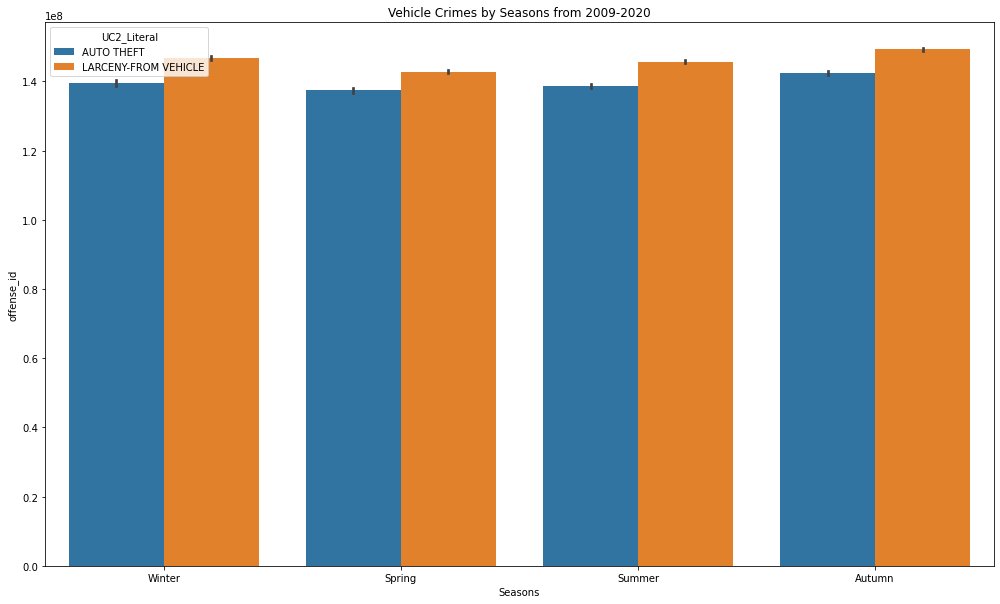

In [42]:
larceny_vehicle_df = crime_consolidated_df.loc[(crime_df["UC2_Literal"]== "AUTO THEFT")|(crime_df["UC2_Literal"]== "LARCENY-FROM VEHICLE")] 
larceny_vehicle_df.head()

larceny_df_df_reset = pd.DataFrame(larceny_vehicle_df).reset_index()
larceny_df_df_reset.head()

#Use Matplotlib to set figure size first
plt.figure(figsize=(17,10))
plt.title("Vehicle Crimes by Seasons from 2009-2020")
#Plot with seaborn
sns.barplot(x = 'Seasons', y = 'offense_id', hue = 'UC2_Literal', data = larceny_df_df_reset)

<AxesSubplot:title={'center':'Vehicle Crimes by Seasons from 2018-2020'}, xlabel='Seasons', ylabel='offense_id'>

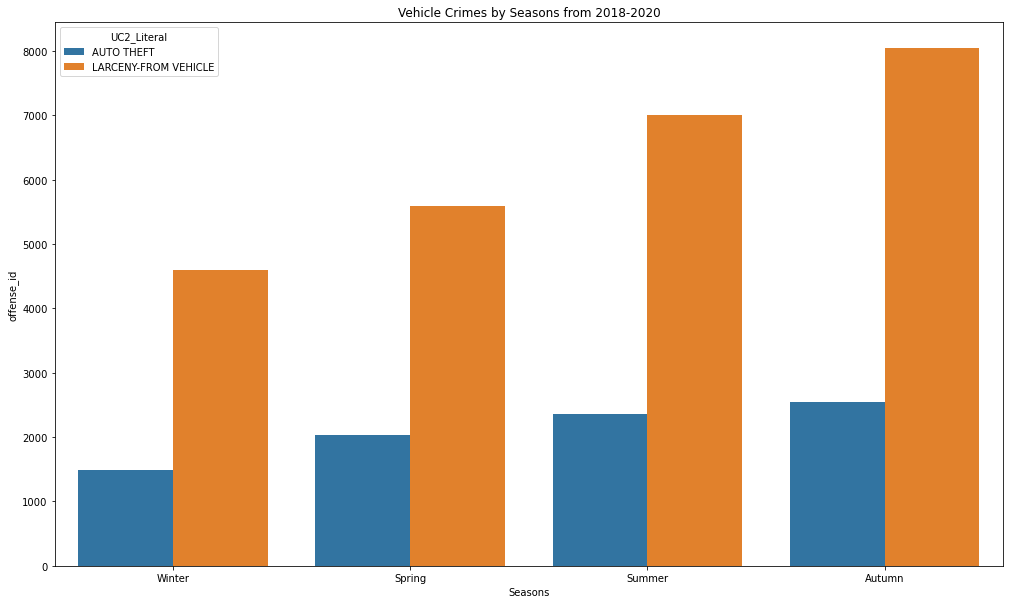

In [62]:
larceny_vehicle_3 = larceny_vehicle_df.loc[(larceny_vehicle_df["occur_year"]==2018) | (larceny_vehicle_df["occur_year"]==2019) | (larceny_vehicle_df["occur_year"]==2020)]
larceny_vehicle_3

larceny_vehicle_3_df =larceny_vehicle_3.groupby(["Seasons", "UC2_Literal"])['offense_id'].count()
larceny_vehicle_3_df.head()

larceny_vehicle_3_df_reset = pd.DataFrame(larceny_vehicle_3_df).reset_index()
larceny_vehicle_3_df_reset.head()

#Use Matplotlib to set figure size first
plt.figure(figsize=(17,10))
plt.title("Vehicle Crimes by Seasons from 2018-2020")
#Plot with seaborn
sns.barplot(x = 'Seasons', y = 'offense_id', hue = 'UC2_Literal', data = larceny_vehicle_3_df_reset)

In [65]:
crime_df_dropped = crime_df.dropna().head()
crime_df_dropped

neighbor_con_drop = crime_consolidated_df.dropna()
neighbor_con_drop

,offense_id,occur_date,occur_time,location,UC2_Literal,neighborhood,lat,long,occur_year,occur_month,Seasons
2198,193340551,11/30/2019,600,156 FORSYTH ST SW,BURGLARY,Downtown,33.75020,-84.39530,2019,11,Autumn
2199,193340336,11/30/2019,230,345 EDGEWOOD AVE SE,AGG ASSAULT,Sweet Auburn,33.75427,-84.37626,2019,11,Autumn
2200,193340509,11/30/2019,500,2950 MARTIN L KING JR DR SW,AGG ASSAULT,Harland Terrace,33.75362,-84.48477,2019,11,Autumn
2201,193340997,11/30/2019,300,925 CANTERBURY RD NE,AGG ASSAULT,Midtown,33.78742,-84.38333,2019,11,Autumn
2202,193341466,11/30/2019,1000,3000 CONTINENTAL COLONY PKWY SW,AGG ASSAULT,Oakland City,33.72559,-84.42586,2019,11,Autumn
...,...,...,...,...,...,...,...,...,...,...,...
364243,200011298,1/1/2020,14:45,2630 MARTIN L KING JR DR SW,AUTO THEFT,Harland Terrace,33.75377,-84.47405,2020,1,Winter
364244,200011823,1/1/2020,20:00,540 HUMPHRIES ST SW,AUTO THEFT,Mechanicsville,33.73990,-84.40488,2020,1,Winter
364245,200020105,1/1/2020,21:45,1174 EUCLID AVE NE,AUTO THEFT,Inman Park,33.76553,-84.34934,2020,1,Winter
364246,200020704,1/1/2020,20:00,383 RALPH MCGILL BLVD NE,AUTO THEFT,Old Fourth Ward,33.76391,-84.37489,2020,1,Winter


In [66]:
###   WTF
neighborhood_data = neighbor_con_drop.loc[neighbor_con_drop["neighborhood"]]
neighborhood_data

KeyError: "None of [Index(['Downtown', 'Sweet Auburn', 'Harland Terrace', 'Midtown',\n       'Oakland City', 'Dixie Hills', 'South Tuxedo Park', 'Westview',\n       'South River Gardens', 'Kings Forest',\n       ...\n       'Downtown', 'Downtown', 'Downtown', 'Old Fourth Ward',\n       'Atlantic Station', 'Harland Terrace', 'Mechanicsville', 'Inman Park',\n       'Old Fourth Ward', 'Midtown'],\n      dtype='object', length=320022)] are in the [index]"

In [ ]:
timeseries....= line graph
barchart = columns w/ categories
count of offense_id 
line chart is a must for the trend (timeseries)
seaborn